In this notebook, we'll be tackling the following problem: given two data sets, how do we find which points are less than some distance apart?

The end goal of this is to use a data structure called kD tree, but we'll explore some other concepts along the way.

Let's start by creating two datasets in 2D, defined in the $[-1,1]$ interval in both axes.

In [2]:
import numpy as np
import matplotlib.pyplot as pl

In [3]:
data_1 = 200*np.random.random((10000,2)) - 100
data_2 = 200*np.random.random((10000,2)) - 100

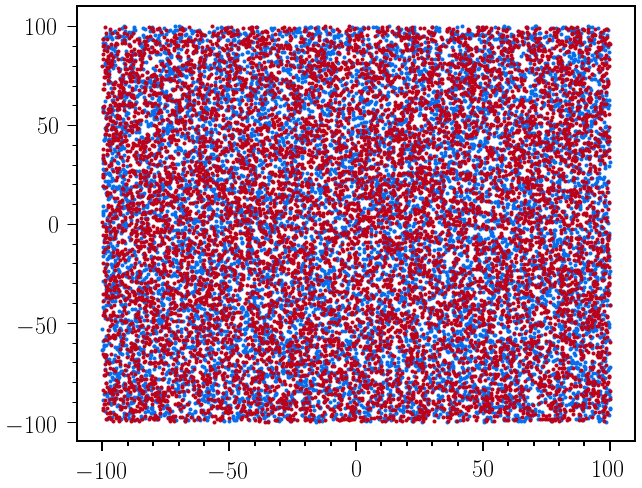

In [4]:
pl.plot(data_1[:,0], data_1[:,1], '.')
pl.plot(data_2[:,0], data_2[:,1], '.')

pl.show()

We wish to find all points in `data_2` that are within distance 1 of points in `data_1`. Let's do the naive implementation first:

In [5]:
%%time
where = []
for i in range(10000):
    point = data_1[i]
    dist = np.sqrt((data_2[:,0] - point[0])**2 + (data_2[:,1] - point[1])**2)
    wh = np.where(dist < 1)[0]
    if len(wh) > 0:
        for j in wh:
            where.append((i,j))

CPU times: user 710 ms, sys: 4.61 ms, total: 714 ms
Wall time: 726 ms


The array `where` has the tuples $(i,j)$ of all the points $i$ in `data_1` that are within distance 1 of points $j$ in `data_2`. 

In [6]:
where

[(4, 6353),
 (4, 9406),
 (5, 5858),
 (5, 9516),
 (8, 1741),
 (10, 2856),
 (10, 6547),
 (11, 4463),
 (11, 9989),
 (12, 3796),
 (12, 8254),
 (15, 2090),
 (16, 9445),
 (17, 1456),
 (18, 5722),
 (19, 6507),
 (20, 4521),
 (21, 2927),
 (21, 9665),
 (22, 46),
 (22, 1157),
 (22, 2403),
 (22, 4574),
 (22, 8196),
 (23, 8200),
 (23, 9781),
 (25, 9137),
 (26, 284),
 (27, 2603),
 (27, 7792),
 (28, 2334),
 (34, 3593),
 (34, 8689),
 (35, 8791),
 (36, 1568),
 (37, 6259),
 (38, 29),
 (38, 6982),
 (39, 9850),
 (40, 6847),
 (42, 3496),
 (43, 5260),
 (43, 6908),
 (43, 9450),
 (44, 3270),
 (44, 3824),
 (44, 9252),
 (45, 61),
 (45, 640),
 (45, 6380),
 (47, 2287),
 (48, 1442),
 (49, 8997),
 (49, 9301),
 (50, 1892),
 (51, 5276),
 (52, 1041),
 (53, 3735),
 (54, 138),
 (54, 1738),
 (55, 8931),
 (56, 738),
 (59, 41),
 (59, 4836),
 (59, 7481),
 (61, 2600),
 (62, 6871),
 (63, 390),
 (63, 8903),
 (67, 2149),
 (68, 1147),
 (68, 2267),
 (69, 5385),
 (69, 5576),
 (70, 4224),
 (74, 3491),
 (75, 293),
 (75, 827),
 (79, 

Let's try to make this faster using kD trees. This is a k-dimensional tree structure that is built for such problems!

In [7]:
from scipy.spatial import KDTree

In [8]:
tree_1 = KDTree(data_1)

In [9]:
%%time
res = tree_1.query_ball_point(data_2,1)


CPU times: user 8 s, sys: 24.5 ms, total: 8.02 s
Wall time: 8.13 s


The `res` array has a similar structure: index $j$ tells me the indices of points in `data_1` that are within distance 1 of point $j$ in `data_2`.

In [45]:
res

array([list([]), list([]), list([1052, 4638, 9070]), ..., list([]),
       list([]), list([7539])], dtype=object)

Wait, that's actually slower... How can we make this faster? Trees can do tree-on-tree searches, so let's make a tree with `data_2`!

In [10]:
tree_2 = KDTree(data_2)

In [11]:
%%time
res = tree_1.query_ball_tree(tree_2,1)


CPU times: user 2.8 s, sys: 117 µs, total: 2.8 s
Wall time: 2.84 s


3x faster than the previous one, but still slower than pure numpy...

There's a trick: the `KDTree` class is, under-the-hood, written in pure Python. Scipy also provides a `cKDTree` class that is written in C instead:

In [12]:
from scipy.spatial import cKDTree
tree_1 = cKDTree(data_1)

In [13]:
%%time
res = tree_1.query_ball_point(data_2,1)


CPU times: user 80.9 ms, sys: 0 ns, total: 80.9 ms
Wall time: 84.1 ms


A lot faster, faster than pure Python!

In [14]:
tree_2 = cKDTree(data_2)

In [15]:
%%time
res = tree_1.query_ball_tree(tree_2,1)


CPU times: user 9.27 ms, sys: 0 ns, total: 9.27 ms
Wall time: 8.6 ms


Almost 6x faster than the numpy implementation.

Let's try the numpy implementation in `numba`:

In [19]:
import numba
@numba.njit("float64[:,:](float64[:,:], float64[:,:])",cache = True)
def search_data(data_1, data_2):
    dist = np.zeros((10000,10000))
    for i in range(10000):
        point = data_1[i]
        for j in range(10000):
            target = data_2[j]
            dist[i,j] = np.sqrt((target[0] - point[0])**2 + (target[1] - point[1])**2)
    return dist


The first time we run it, it'll be slow, as it's compiling the function.

In [20]:
%%time
search_data(data_1, data_2)

CPU times: user 519 ms, sys: 220 ms, total: 739 ms
Wall time: 742 ms


array([[194.16063677, 234.96941113, 124.47284317, ...,  24.43473176,
        168.99304279,  74.93870783],
       [100.07229823, 124.07967274,  66.47292693, ...,  87.96514947,
        125.68354846,  51.31005356],
       [ 28.60621286,  87.01383711, 129.74872875, ..., 152.99234517,
        180.8382764 , 103.7513517 ],
       ...,
       [162.56122017, 218.02271429, 130.61154136, ...,  27.94276461,
        184.05235677,  47.28430753],
       [ 71.3636891 , 103.2377137 ,  88.23009343, ..., 112.95495933,
        144.05114882,  68.19850225],
       [ 97.04034505, 152.68707144, 102.9939406 , ...,  72.88514579,
        162.92885975,  22.27406904]])

In [22]:
search_data(np.int32(data_1), data_2)

TypeError: No matching definition for argument type(s) array(int32, 2d, C), array(float64, 2d, C)

In [36]:
@numba.jit("float64[:,:](float64[:,:], float64[:,:])", cache=True, nopython = False)
def search_data_vec(data_1, data_2):
    dist = np.zeros((10000,10000))
    for i in range(10000):
        point = data_1[i]
        dist[i,:] = np.sqrt((data_2[:,0] - point[0])**2 + (data_2[:,1] - point[1])**2)
    return dist

In [37]:
%%time
search_data_vec(data_1, data_2)

CPU times: user 644 ms, sys: 237 ms, total: 880 ms
Wall time: 5.54 s


array([[194.16063677, 234.96941113, 124.47284317, ...,  24.43473176,
        168.99304279,  74.93870783],
       [100.07229823, 124.07967274,  66.47292693, ...,  87.96514947,
        125.68354846,  51.31005356],
       [ 28.60621286,  87.01383711, 129.74872875, ..., 152.99234517,
        180.8382764 , 103.7513517 ],
       ...,
       [162.56122017, 218.02271429, 130.61154136, ...,  27.94276461,
        184.05235677,  47.28430753],
       [ 71.3636891 , 103.2377137 ,  88.23009343, ..., 112.95495933,
        144.05114882,  68.19850225],
       [ 97.04034505, 152.68707144, 102.9939406 , ...,  72.88514579,
        162.92885975,  22.27406904]])

Still slower than the cKD tree! But note that this computes the distance only, and you need to do `np.where(dist[dist < 1])` to get the results.

Now let's try compiling a parallel version of this function:

In [27]:
@numba.njit("float64[:,:](float64[:,:], float64[:,:])",parallel=True, cache=True)
def search_data_parallel(data_1, data_2):
    dist = np.zeros((10000,10000))
    for i in numba.prange(10000):
        point = data_1[i]
        for j in numba.prange(10000):
            target = data_2[j]
            dist[i,j] = np.sqrt((target[0] - point[0])**2 + (target[1] - point[1])**2)
    return dist


In [34]:
%%time
search_data_parallel(data_1, data_2)

CPU times: user 613 ms, sys: 405 ms, total: 1.02 s
Wall time: 6.49 s


array([[194.16063677, 234.96941113, 124.47284317, ...,  24.43473176,
        168.99304279,  74.93870783],
       [100.07229823, 124.07967274,  66.47292693, ...,  87.96514947,
        125.68354846,  51.31005356],
       [ 28.60621286,  87.01383711, 129.74872875, ..., 152.99234517,
        180.8382764 , 103.7513517 ],
       ...,
       [162.56122017, 218.02271429, 130.61154136, ...,  27.94276461,
        184.05235677,  47.28430753],
       [ 71.3636891 , 103.2377137 ,  88.23009343, ..., 112.95495933,
        144.05114882,  68.19850225],
       [ 97.04034505, 152.68707144, 102.9939406 , ...,  72.88514579,
        162.92885975,  22.27406904]])

In [35]:
@numba.njit("float64[:,:](float64[:,:], float64[:,:])",parallel=True, cache=True)
def search_data_vectorized(data_1, data_2):
    dist = np.zeros((10000,10000))
    for i in numba.prange(10000):
        point = data_1[i]
        dist[i,:] = np.sqrt((data_2[:,0] - point[0])**2 + (data_2[:,1] - point[1])**2)
    return dist


In [32]:
%%time
search_data_vectorized(data_1, data_2)

CPU times: user 511 ms, sys: 422 ms, total: 933 ms
Wall time: 479 ms


array([[194.16063677, 234.96941113, 124.47284317, ...,  24.43473176,
        168.99304279,  74.93870783],
       [100.07229823, 124.07967274,  66.47292693, ...,  87.96514947,
        125.68354846,  51.31005356],
       [ 28.60621286,  87.01383711, 129.74872875, ..., 152.99234517,
        180.8382764 , 103.7513517 ],
       ...,
       [162.56122017, 218.02271429, 130.61154136, ...,  27.94276461,
        184.05235677,  47.28430753],
       [ 71.3636891 , 103.2377137 ,  88.23009343, ..., 112.95495933,
        144.05114882,  68.19850225],
       [ 97.04034505, 152.68707144, 102.9939406 , ...,  72.88514579,
        162.92885975,  22.27406904]])

As fast as the non-vectorized version!